In [1]:
import numpy as np
import pandas as pd

# decision tree
## Overview
A decision tree fundamentally mirrors the architecture of a binary tree. Within this structure, individual nodes are associated with specific features from the dataset. The threshold set at each of these nodes acts as the deciding parameter. a very rudimentary decision tree with just one decision point (the root node) and two possible outcomes or predictions (A or B), and it can be implemented by:

In [3]:
class DecisionNode:
    def __init__(self, feature=None, threshold=None, data=None, true_branch=None, false_branch=None):
        self.feature = feature
        self.threshold = threshold
        self.data = data  # this is the prediction value for leaf nodes
        self.true_branch = true_branch
        self.false_branch = false_branch

    def predict(self, instance):
        if self.feature is None:  # indicates it's a leaf node
            return self.data

        if instance[self.feature] < self.threshold:
            return self.true_branch.predict(instance)
        else:
            return self.false_branch.predict(instance)

# Example usage:

# Constructing a simple tree for a binary decision on a single feature.
# For instance: if feature[0] < 5, predict "A", else predict "B"
root = DecisionNode(feature=0, threshold=5)
root.true_branch = DecisionNode(data="A")
root.false_branch = DecisionNode(data="B")

# Testing
instance1 = {0: 3}
print(root.predict(instance1))  # Output: A

instance2 = {0: 7}
print(root.predict(instance2))  # Output: B

A
B


The depth of the decision tree is an important parameter for a tree. While we might predefine the depth of a tree, its exact structure remains undetermined. In essence, the parent-child relationships, which define the tree's structure, can also be viewed as 'parameters' of the tree. The tree doesn't just grow to a fixed depth; it grows based on optimizing the classification of data. To ensure we grow the tree in the most effective manner, we use measures like Gini impurity or entropy. These metrics guide the decision-making process at each node, helping to determine the best feature and threshold to split the data. I will learn the Gini impurity and CART (used in this paper) in the next section.

## Gini impurity
Gini impurity is a measure of how often a randomly chosen element would be incorrectly classified. It provides a way to quantify the disorder or the impurity in a set of items. In the context of decision trees, specifically the CART (Classification and Regression Trees) algorithm, the Gini impurity is used as a criterion to decide the best feature/split at each node.

For a **binary** classification:
$$\text{Gini Impurity} = 2p(1-p)$$

If there are C classes and $p_{i}$ is the probability of choosing an item from class $i$, then the Gini impurity is given by:
$$\text{Gini Impurity} = 1 - \sum_{i=1}^{C}p_{i}^{2}$$

the function of gini impurity is like the loss function in neural network

In [4]:
def gini_impurity(y):
    m = len(y)
    # go through all classes and calculate the prob. for each class
    return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

y_1 = np.array(['A', 'A', 'B', 'B', 'B', 'A'])
print(f'the gini impurity of y_1 is {gini_impurity(y_1)}')

the gini impurity of y_1 is 0.5


## CART algorithm to growing the tree
### 1. Initialization:
- Start with all data at the root.
- Calculate the Gini Impurity for the entire dataset.

### 2. Feature Selection for Split:
For every feature:
   - Sort the data by that feature's values.
   - Calculate the Gini Impurity for every possible split.
   - Choose the split that gives the maximum reduction in Gini Impurity.


A very simple example is showing below:

Assume we're trying to classify whether fruits are Apples or Oranges based on their weight and color.

| Weight (grams) | Color (0: Green, 1: Orange) | Fruit  |
|----------------|-----------------------------|--------|
| 180            | 1                           | Orange |
| 160            | 0                           | Apple  |
| 170            | 1                           | Orange |
| 150            | 0                           | Apple  |

**Weight Feature Analysis**:
- Split at 165 grams:
   - Left: 2 Apples
   - Right: 2 Oranges
   - Gini Reduction = Gini_original - (Gini_left + Gini_right)
     $$Gini(original) = 1 - (0.5^{2} + 0.5^{2}) $$
     $$Gini(left) = Gini(right) = 0 $$

In this example, both the weight and color features perfectly separate the dataset. However, in more complex datasets, some splits will be better than others, and that's where the Gini impurity comes into play: to quantify how good each potential split is. The split that results in the largest reduction in Gini impurity is chosen at each step.

**Note**:

The process of building a decision tree is **inherently greedy**. At each step, the algorithm makes the locally optimal choice by selecting the split that provides the most immediate reduction in impurity. This does not guarantee a globally optimal tree.

## Example 1: features are categorical
Explore a more complex example and code it.

Dataset:

Suppose we have a dataset of individuals describing their job type, age category, and whether they bought a specific product. the data can be represented as:

| Job      | Age         | Bought |
|----------|-------------|--------|
| Engineer | Young       | No     |
| Engineer | Middle-aged | No     |
| Doctor   | Senior      | Yes    |
| ...      | ...         | ...    |
| Engineer | Middle-aged | Yes    |

In [5]:
data = [["Engineer", "Young", "No"],
    ["Engineer", "Middle-aged", "No"],
    ["Doctor", "Senior", "Yes"],
    ["Doctor", "Young", "Yes"],
    ["Engineer", "Senior", "Yes"],
    ["Artist", "Middle-aged", "Yes"],
    ["Artist", "Young", "No"],
    ["Doctor", "Middle-aged", "No"],
    ["Artist", "Senior", "Yes"],
    ["Engineer", "Middle-aged", "Yes"]
]

df = pd.DataFrame(data, columns=["Occupation", "Age", "Buy"])
print(df)

  Occupation          Age  Buy
0   Engineer        Young   No
1   Engineer  Middle-aged   No
2     Doctor       Senior  Yes
3     Doctor        Young  Yes
4   Engineer       Senior  Yes
5     Artist  Middle-aged  Yes
6     Artist        Young   No
7     Doctor  Middle-aged   No
8     Artist       Senior  Yes
9   Engineer  Middle-aged  Yes


So first we gonna manually grow the tree, then write the recursive algorithm。

In [6]:
# the original gini impurity is
gini_ori = gini_impurity(df['Buy'])
print(f'the original gini impurity is {gini_ori}')

the original gini impurity is 0.48


In [7]:
np.sum(df['Age'] == 'Young') / len(df)

0.3

In [8]:
# if first we split by age:
## if split with young and not young
feature = 'Young'
gini_feature = gini_impurity(df[df["Age"] == feature]["Buy"])
gini_not_feature = gini_impurity(df[df["Age"] != feature]["Buy"])

weighed_gini = (np.sum(df['Age'] == feature) / len(df) * gini_feature 
                + np.sum(df['Age'] != feature) / len(df) * gini_not_feature)
print(weighed_gini, gini_ori - weighed_gini)

0.419047619047619 0.06095238095238098


In [9]:
## if split with middle-aged or not
feature = 'Middel-age'
gini_feature = gini_impurity(df[df["Age"] == feature]["Buy"])
gini_not_feature = gini_impurity(df[df["Age"] != feature]["Buy"])
print(gini_feature, gini_not_feature)

weighed_gini = (np.sum(df['Age'] == feature) / len(df) * gini_feature 
                + np.sum(df['Age'] != feature) / len(df) * gini_not_feature)
print(weighed_gini, gini_ori - weighed_gini)

1.0 0.48
0.48 0.0


In [10]:
## if split with senior or not
feature = 'Senior'
gini_feature = gini_impurity(df[df["Age"] == feature]["Buy"])
gini_not_feature = gini_impurity(df[df["Age"] != feature]["Buy"])
print(gini_feature, gini_not_feature)

weighed_gini = (np.sum(df['Age'] == feature) / len(df) * gini_feature 
                + np.sum(df['Age'] != feature) / len(df) * gini_not_feature)
print(weighed_gini, gini_ori - weighed_gini)

0.0 0.48979591836734704
0.3428571428571429 0.13714285714285707


In [11]:
# if we split by job
## if split by Engineer
feature = 'Engineer'
gini_feature = gini_impurity(df[df["Occupation"] == feature]["Buy"])
gini_not_feature = gini_impurity(df[df["Occupation"] != feature]["Buy"])
print(gini_feature, gini_not_feature)

weighed_gini = (np.sum(df['Occupation'] == feature) / len(df) * gini_feature 
                + np.sum(df['Occupation'] != feature) / len(df) * gini_not_feature)
print(weighed_gini, gini_ori - weighed_gini)

0.5 0.4444444444444444
0.4666666666666667 0.013333333333333308


In [12]:
## if split by Doctor
feature = 'Doctor'
gini_feature = gini_impurity(df[df["Occupation"] == feature]["Buy"])
gini_not_feature = gini_impurity(df[df["Occupation"] != feature]["Buy"])
print(gini_feature, gini_not_feature)

weighed_gini = (np.sum(df['Occupation'] == feature) / len(df) * gini_feature 
                + np.sum(df['Occupation'] != feature) / len(df) * gini_not_feature)
print(weighed_gini, gini_ori - weighed_gini)

0.4444444444444444 0.48979591836734704
0.4761904761904763 0.003809523809523707


In [13]:
## if split by Doctor
feature = 'Artist'
gini_feature = gini_impurity(df[df["Occupation"] == feature]["Buy"])
gini_not_feature = gini_impurity(df[df["Occupation"] != feature]["Buy"])
print(gini_feature, gini_not_feature)

weighed_gini = (np.sum(df['Occupation'] == feature) / len(df) * gini_feature 
                + np.sum(df['Occupation'] != feature) / len(df) * gini_not_feature)
print(weighed_gini, gini_ori - weighed_gini)

0.4444444444444444 0.48979591836734704
0.4761904761904763 0.003809523809523707


therefore we split all feature in round 1, and then we have the all the diff of gini, then obviously, the first feature we should pick is "Senior". I will not go through the whole tree. Let's write the code method now.

In [15]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = {}

    def try_split(self, X, y, feature_index, value):
        left_mask = (X[:, feature_index] == value)
        right_mask = (X[:, feature_index] != value)
        left_impurity = gini_impurity(y[left_mask])
        right_impurity = gini_impurity(y[right_mask])
        return left_impurity, right_impurity, left_mask, right_mask

    def best_split(self, X, y):
        m, n = X.shape
        best_gain = 0
        best_feature_index = None
        best_value = None
        best_masks = None
        parent_impurity = gini_impurity(y)

        for feature_index in range(n):
            values = np.unique(X[:, feature_index])
            for value in values:
                left_impurity, right_impurity, left_mask, right_mask = self.try_split(
                    X, y, feature_index, value)
                gain = parent_impurity - (
                            left_impurity * left_mask.sum() + right_impurity * right_mask.sum()) / m
                if gain > best_gain:
                    best_gain = gain
                    best_feature_index = feature_index
                    best_value = value
                    best_masks = (left_mask, right_mask)
        return best_feature_index, best_value, best_masks

    def build_tree(self, X, y, depth=0):
        num_samples_per_class, num_samples = np.unique(y, return_counts=True)
        if len(num_samples_per_class) == 1 or (self.max_depth is not None and depth == self.max_depth):
            # Return the majority class directly using counts
            majority_class_index = np.argmax(num_samples)
            return num_samples_per_class[majority_class_index]
        else:
            idx, val, masks = self.best_split(X, y)
            if idx is None:  # No split was found
                majority_class_index = np.argmax(num_samples)
                return num_samples_per_class[majority_class_index]

            left_mask, right_mask = masks
            left = self.build_tree(X[left_mask], y[left_mask], depth + 1)
            right = self.build_tree(X[right_mask], y[right_mask], depth + 1)
            return (idx, val, left, right)

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def _predict_one(self, inputs):
        node = self.tree
        while isinstance(node, tuple):
            idx, val, left, right = node
            node = left if inputs[idx] == val else right
        return node

    def predict(self, X):
        return np.array([self._predict_one(inputs) for inputs in X])

In [16]:
# format our dataset
data_number = np.array([
    [0, 0],
    [0, 1],
    [1, 2],
    [1, 0],
    [0, 2],
    [2, 1],
    [2, 0],
    [1, 1],
    [2, 2],
    [0, 1],
])
# Labels
labels = np.array([0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [19]:
dt = DecisionTree(max_depth=10)
# print(dt.best_split(data_number, labels))

dt.fit(data_number, labels)
print(dt.predict(data_number))
print(labels)

[0 0 1 0 1 0 0 0 1 0]
[0 0 1 1 1 1 0 0 1 1]


## Example 2: Features are numarical

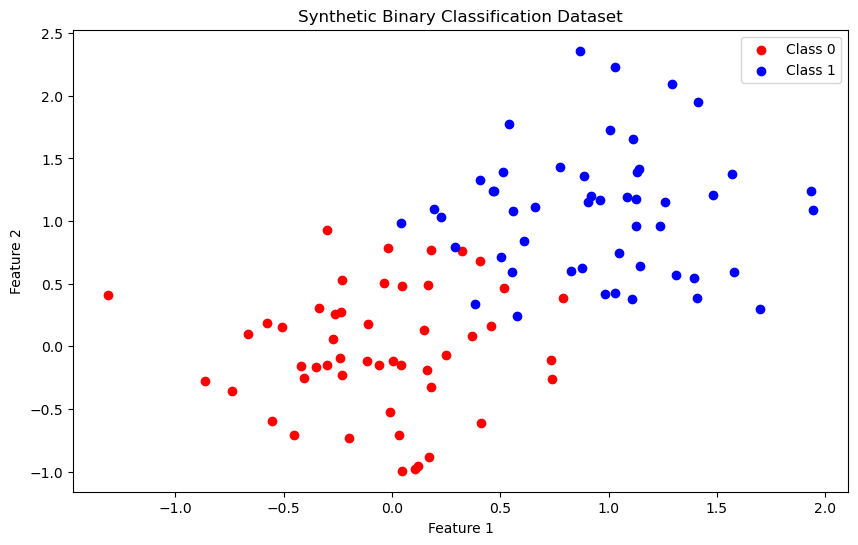

In [2]:
# first we gonna generate a dataset
import matplotlib.pyplot as plt

# Seed the random number generator for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 100

# Generate random points for class 0
class_0 = np.random.normal(0, 0.5, (n_samples // 2, 2))

# Generate random points for class 1
class_1 = np.random.normal(1, 0.5, (n_samples // 2, 2))

# Concatenate the points to form the feature set
X = np.vstack((class_0, class_1))

# Generate the labels
y = np.array([0] * (n_samples // 2) + [1] * (n_samples // 2))

# Plot the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1')
plt.title('Synthetic Binary Classification Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [4]:
import numpy as np


def gini_impurity(y):
    m = len(y)
    return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))


class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def try_split(self, X, y, feature_index):
        # Sort the data along the feature
        sorted_indices = X[:, feature_index].argsort()
        X_sorted, y_sorted = X[sorted_indices], y[sorted_indices]
        
        # Now we need to find the best split
        best_gain = 0
        best_split = None
        best_value = None
        parent_impurity = gini_impurity(y)
        m = len(y)

        for i in range(1, m):  # We start at 1, because we need to split at least one element to the left
            if X_sorted[i, feature_index] != X_sorted[i - 1, feature_index]:
                left_impurity = gini_impurity(y_sorted[:i])
                right_impurity = gini_impurity(y_sorted[i:])
                gain = parent_impurity - (left_impurity * i + right_impurity * (m - i)) / m
                if gain > best_gain:
                    best_gain = gain
                    best_split = i
                    best_value = (X_sorted[i, feature_index] + X_sorted[i - 1, feature_index]) / 2  # Midpoint

        return best_gain, best_value

    def build_tree(self, X, y, depth=0):
        num_samples_per_class, num_samples = np.unique(y, return_counts=True)
        if len(num_samples_per_class) == 1 or (self.max_depth is not None and depth == self.max_depth):
            majority_class_index = np.argmax(num_samples)
            return num_samples_per_class[majority_class_index]
        else:
            best_gain = 0
            best_idx = None
            best_value = None
            for feature_index in range(X.shape[1]):
                gain, value = self.try_split(X, y, feature_index)
                if gain > best_gain:
                    best_gain = gain
                    best_idx = feature_index
                    best_value = value
            
            if best_gain == 0:
                majority_class_index = np.argmax(num_samples)
                return num_samples_per_class[majority_class_index]

            # Split the dataset and recurse on each child
            left_mask = X[:, best_idx] < best_value
            right_mask = ~left_mask
            left = self.build_tree(X[left_mask], y[left_mask], depth + 1)
            right = self.build_tree(X[right_mask], y[right_mask], depth + 1)
            return (best_idx, best_value, left, right)

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def _predict_one(self, inputs):
        node = self.tree
        while isinstance(node, tuple):
            feature_index, value, left, right = node
            node = left if inputs[feature_index] < value else right
        return node

    def predict(self, X):
        return np.array([self._predict_one(inputs) for inputs in X])


# Example usage with numerical features
if __name__ == '__main__':
    # Assuming data_number is your dataset with numerical features
    # Assuming labels is your target variable

    dt = DecisionTree(max_depth=3)
    dt.fit(X, y)
    predictions = dt.predict(X)

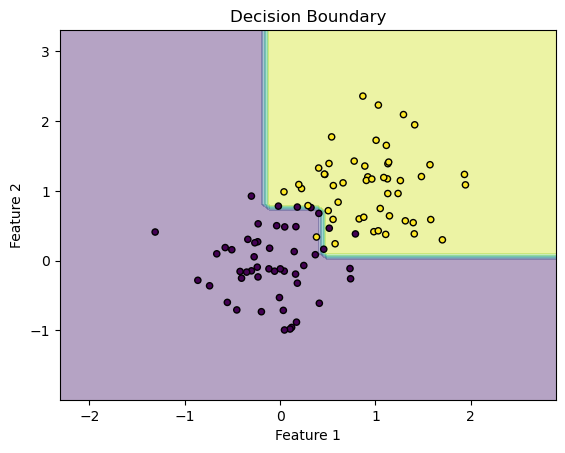

In [5]:
def plot_decision_boundary(clf, X, y):
    # Plotting ranges
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predictions to obtain the decision boundary
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour and training points
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    plt.title("Decision Boundary")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

# ... (previous code for generating dataset and training model)

# Plot the decision boundary
plot_decision_boundary(dt, X, y)
plt.show()